In [98]:
# Evan was here

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.table import Table
import pickle
import os

%matplotlib inline

plt.rcParams.update({'font.size': 16})

In [99]:
cf = pd.read_feather('run21_coadds.feather')  # results of chemfit
nf = pd.read_feather('umi_assignments_all.feather')  # results of netflow
targets = pd.read_feather('umi_targets_hsc.feather')

nf = pd.merge(nf, targets[['targetid', 'obs_hsc_i', 'obs_hsc_g',
       'obs_hsc_nb515', 'err_hsc_i', 'err_hsc_g', 'err_hsc_nb515', 'cli',
       'clg', 'cln', 'ext_hsc_g', 'ext_hsc_i', 'ext_hsc_nb515']], how='inner', on='targetid')

print(nf)  # print the dataframe called nf

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [100]:

cf = cf[np.isfinite(cf['ra']) & np.isfinite(cf['dec'])]
nf = nf[np.isfinite(nf['RA']) & np.isfinite(nf['Dec']) & (nf['key'] == 'hsc')]

skycoord_cf = SkyCoord(ra=cf['ra']*u.deg, dec=cf['dec']*u.deg, unit=u.deg)
skycoord_nf = SkyCoord(ra=nf['RA']*u.deg, dec=nf['Dec']*u.deg, unit=u.deg)
idx, d2d, _ = skycoord_cf.match_to_catalog_sky(skycoord_nf)

max_sep = 0.5 * u.arcsec

# Only keep matches within max_sep
mask = (d2d < max_sep)

# Filter cf and idx accordingly
cf_matched = cf[mask]
idx_matched = idx[mask]
d2d = d2d[mask]
#cat = cf.join(nf, how='inner', rsuffix='_nf', lsuffix='_cf', on=idx)
cat = pd.merge(cf_matched.reset_index(drop=True),
    nf.iloc[idx_matched].reset_index(drop=True),
    left_index=True,
    right_index=True
)

def nJy_to_mag(nJy):
    return -2.5 * np.log10(nJy*1e-9 / 3631)

def nJy_to_mag_err(nJy_frac_err):
    return 2.5 / np.log(10) * nJy_frac_err

cat['mag'] = cat['psf_flux'].apply(lambda x: nJy_to_mag(x))
cat['mag_err'] = (cat['psf_flux_err']/cat['psf_flux']).apply(lambda x: nJy_to_mag_err(x))

def get_mag(m, f, f_expected):
    index = np.where(f == f_expected)[0]
    if not index:
        val = np.nan
    val = m[index[0]] if isinstance(m, (list, np.ndarray)) and len(m) > index and f[index] == f_expected else np.nan
    return val

'''
g = np.array([get_mag(m,f,'g_hsc') for (m,f) in zip(cat['mag'], cat['filter']) ])
i = np.array([get_mag(m,f,'i_hsc') for (m,f) in zip(cat['mag'], cat['filter']) ])
n = np.array([get_mag(m,f,'nb515_hsc') for (m,f) in zip(cat['mag'], cat['filter']) ])
gerr = np.array([get_mag(m,f,'g_hsc') for (m,f) in zip(cat['mag_err'], cat['filter']) ])
ierr = np.array([get_mag(m,f,'i_hsc') for (m,f) in zip(cat['mag_err'], cat['filter']) ])
nerr = np.array([get_mag(m,f,'nb515_hsc') for (m,f) in zip(cat['mag_err'], cat['filter']) ])
'''

g = np.array(cat['obs_hsc_g'] - cat['ext_hsc_g'])
i = np.array(cat['obs_hsc_i'] - cat['ext_hsc_i'])
n = np.array(cat['obs_hsc_nb515'] - cat['ext_hsc_nb515'])
gerr = np.array(cat['err_hsc_g'])
ierr = np.array(cat['err_hsc_i'])
nerr = np.array(cat['err_hsc_nb515'])

Mean velocity: -247.66 km/s
Velocity dispersion: 11.11 km/s
Velocity range: -280.97 to -214.34 km/s
Number of members: 400


Text(0, 0.5, '$\\log g$ [cm/s$^2$]')

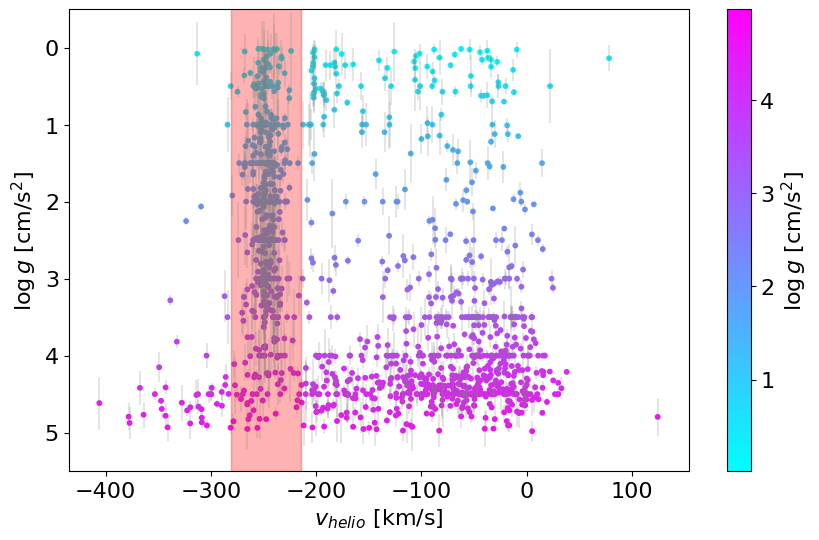

In [101]:
mask = (cat['stage_1_redshift_err'] < 3) & (cat['stage_2_logg_err'] < 0.5) & (cat['stage_2_logg'] > 0.01) & (cat['stage_2_logg'] < 4.99)
mems = (cat['stage_1_redshift'] > -280) & (cat['stage_1_redshift'] < -216) & (cat['stage_2_logg'] < 4.99)
nonmems = ~mems
mems = mask & mems
nonmems = mask & nonmems

vmean = np.mean(cat.loc[mems, 'stage_1_redshift'])
vdisp = np.std(cat.loc[mems, 'stage_1_redshift'])
print(f"Mean velocity: {vmean:.2f} km/s")
print(f"Velocity dispersion: {vdisp:.2f} km/s")

vlow = vmean - 3 * vdisp
vhigh = vmean + 3 * vdisp
print(f"Velocity range: {vlow:.2f} to {vhigh:.2f} km/s")

mems = (cat['stage_1_redshift'] > vlow) & (cat['stage_1_redshift'] < vhigh) & (cat['stage_2_logg'] < 4.99) & (cat['priority'] <= 2) & ~pd.isna(cat['priority'])
nonmems = ~mems
mems = mask & mems
nonmems = mask & nonmems
print(f"Number of members: {np.sum(mems)}")

plt.figure(figsize=(10, 6))
plt.errorbar(cat.loc[nonmems,'stage_1_redshift'], cat.loc[nonmems,'stage_2_logg'], xerr=cat.loc[nonmems,'stage_1_redshift_err'], yerr=cat.loc[nonmems,'stage_2_logg_err'], fmt='.', markersize=0.1, alpha=0.2, c='gray')
plt.errorbar(cat.loc[mems,'stage_1_redshift'], cat.loc[mems,'stage_2_logg'], xerr=cat.loc[mems,'stage_1_redshift_err'], yerr=cat.loc[mems,'stage_2_logg_err'], fmt='.', markersize=0.1, alpha=0.2, c='gray')
plt.scatter(cat.loc[mask,'stage_1_redshift'], cat.loc[mask,'stage_2_logg'], alpha=1, s=10, c=cat.loc[mask,'stage_2_logg'], cmap='cool')
plt.fill_between([vlow, vhigh], [-100, -100], [100, 100], color='red', alpha=0.3)
#plt.colorbar(label=r'priority')
plt.colorbar(label=r'$\log g$ [cm/s$^2$]')
plt.ylim(5.5, -0.5)
plt.xlabel(r'$v_{helio}$ [km/s]')
plt.ylabel(r'$\log g$ [cm/s$^2$]')

In [102]:
# Step 1: Write a function that takes an objId and a wavelength range, and plots the spectrum for that objId in the specified wavelength range.
# Step 2: Write some code to figure out the objId of a star from the color-magnitude diagram.
# Step 3: Plot the spectrum of a star when you click on it in the color-magnitude diagram.

def plot_spectrum(objId, wl_range=[4500, 5000]):
    import matplotib.pyplot as plt
    import pandas as pd
    try:
        cat= pd.read_feather('umi_assignments_all.feather')
    except FileNotFoundError:
        np.random.seed(0)
        cat= pd.DataFrame({'g-i':np.random.uniform(0.5,2.0,500),'i':np.random.uniform(15,20,500), 'objId':np.arange(1000,1500)})
    desired_star= (cat['g-i']> 1.1) & (cat[i]<17)
    if len(cat[desired_star])==0:
        print('no such star')
    else:
        objId = cat[desired_star]['objId'].values[0]
        print(f"objId:{objId}")

    
                    


    
	

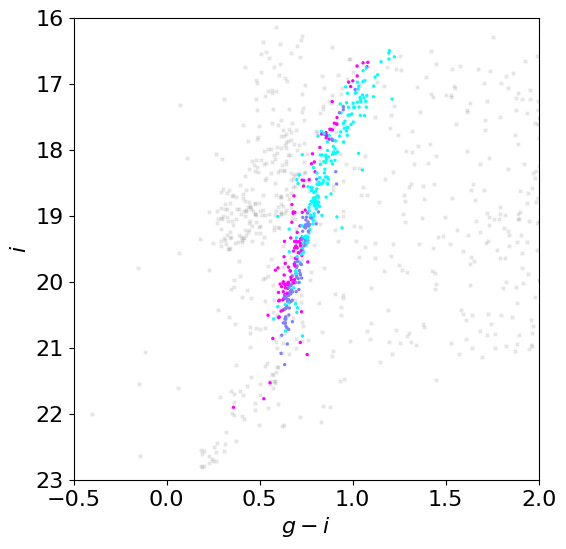

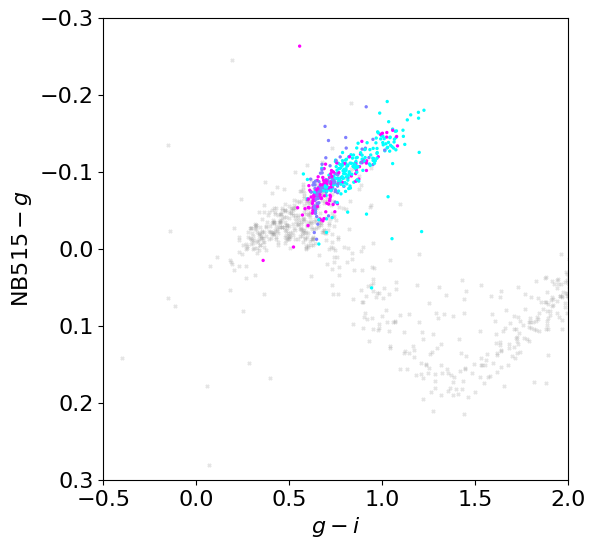

In [103]:
# Color-magnitude diagram.  Left = blue (hot), right = red (cool), bottom = faint, top = bright

plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[nonmems], i[nonmems], s=5, alpha=0.2, marker='x', color='gray')
plt.scatter((g-i)[mems], i[mems], c=cat.loc[mems,'priority'], s=2, alpha=1.0, cmap='cool')
#plt.colorbar(label=r'priority')
plt.xlim(-0.5, 2.0)
plt.ylim(23, 16)
plt.xlabel(r'$g - i$')
plt.ylabel(r'$i$')

plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[nonmems], (n-g)[nonmems], s=5, alpha=0.2, marker='x', color='gray')
plt.scatter((g-i)[mems], (n-g)[mems], c=cat.loc[mems,'priority'], s=2, alpha=1.0, cmap='cool')
plt.xlim(-0.5, 2.0)
plt.ylim(0.3, -0.3)
plt.xlabel(r'$g - i$')
plt.ylabel(r'${\rm NB515} - g$')
plt.show()

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/994183062.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cat.loc[mems, 'stage_2_teff'], (g-i)[mems], s=2, alpha=0.5, c='black', cmap='cool')
/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/994183062.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cat.loc[mask, 'stage_2_teff'], (g-i)[mask], s=2, alpha=1.0, c='red', cmap='cool')


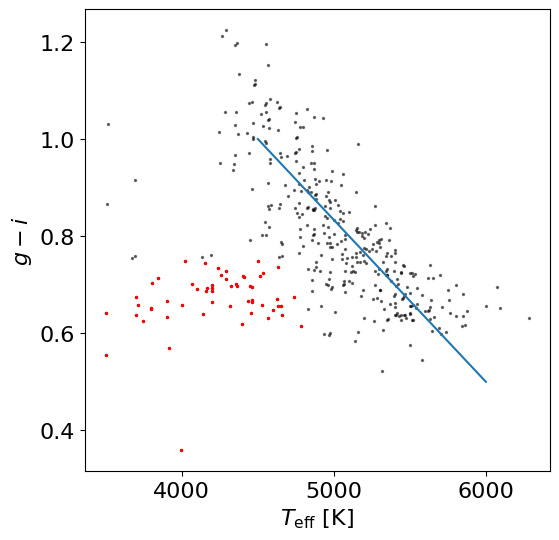

[19.50377035 20.03857849 19.77891943 20.0422753  19.70176624 20.06150955
 20.26980044 19.41085308 19.44481236 19.70288166 20.31839018 19.41113182
 20.67427272 21.90300966 19.76006275 20.1513199  19.93071316 19.33334646
 20.72275166 19.62127764 20.85864962 19.5461536  20.53179668 20.43071541
 20.20591722 19.89742035 19.15397544 18.55082545 20.92025169 20.0005083
 20.15108233 19.15842925 19.87541822 20.62598718 19.96881691 20.81048028
 19.73191817 19.83857231 20.33276891 21.25587858 21.0860405  20.2023798
 19.87735652 20.39446097 19.83513075 20.01576906 20.70148131 19.45717502
 19.20249675 20.11939699 20.15018969 20.27949858 19.64688763 21.53129534
 20.29679724 19.58295309]


In [104]:
# Make a plot of (g-i) vs. Teff.

mask = ((g-i) < 0.75) & mems & (cat['stage_2_teff'] < 4800)

plt.figure(figsize=(6,6))
plt.scatter(cat.loc[mems, 'stage_2_teff'], (g-i)[mems], s=2, alpha=0.5, c='black', cmap='cool')
plt.scatter(cat.loc[mask, 'stage_2_teff'], (g-i)[mask], s=2, alpha=1.0, c='red', cmap='cool')
plt.xlabel(r'$T_{\rm eff}$ [K]')
plt.ylabel(r'$g - i$')
plt.plot([6000, 4500], [0.5, 1.0])
plt.show()

# What are the names ("targetid") of the stars that are members and have (g-i) < 0.75 and Teff < 4800 K?

#print(cat.loc[mask, 'targetid'])

# What are the i magnitudes of these stars?

print(i[mask])

2       5059.673637
3       4655.878653
10      4695.889720
13      4875.759057
18      4439.124098
19      5267.805438
22      5277.916351
25      4288.691475
50      4855.951857
81      4623.464317
88      5327.257601
106     4940.008404
109     4936.242136
112     5402.868738
115     5238.461463
116     4752.107481
125     5321.889825
133     4877.197109
134     4344.513924
136     4564.893704
140     4634.244679
143     3513.018910
145     4554.125262
149     4950.990161
151     5456.913970
173     5405.453453
196     5349.468364
235     4912.955780
236     5057.520350
238     5404.697112
243     4681.647647
249     5520.586855
262     5849.793363
265     5633.858455
281     4787.992896
282     5178.917475
293     5471.029182
302     4866.464133
305     4826.729811
306     4528.245620
311     5409.025334
314     5351.938102
327     4655.540246
342     5417.797585
352     4797.189092
377     4987.329927
378     5311.192139
382     4658.701107
383     5840.722103
400     4264.295375


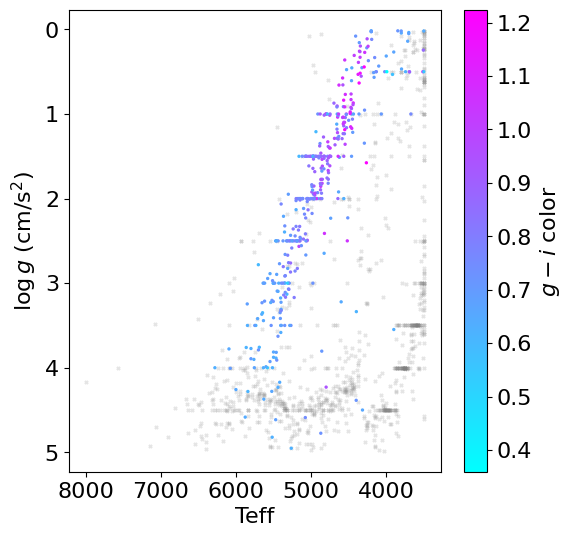

In [105]:
# Plot of temperature-gravity diagram.  This diagram should look similar to the color-magnitude diagram.  However, instead of plotting color on the x-axis, you will plot temperature.
# Instead of plotting magnitude on the y-axis, you will plot log(g).  g is the "surface gravity" of the star, which is a measure of how strong the gravitational force is at the surface
# of the star.  It is related to the mass and radius of the star.


# Susie's job: turn this code into a diagram of Teff-log(g)
# x-axis: cat['stage_2_teff']
# y-axis: cat['stage_2_logg']

# homework: Change the color-coding of the plot to be (g-i) color, not logg.

print(cat.loc[mems,'stage_2_teff'])

plt.figure(figsize=(6, 6)) 
plt.scatter(cat.loc[nonmems,'stage_2_teff'], cat.loc[nonmems,'stage_2_logg'], s=5, alpha=0.2, marker='x', color='gray')      # plot the non-members in gray
plt.scatter(cat.loc[mems,'stage_2_teff'], cat.loc[mems,'stage_2_logg'], c=(g-i)[mems], s=2, alpha=1.0, cmap='cool')    # plot the members in color based on log(g)
plt.colorbar(label=r'$g-i$ color')
#plt.xlim(-0.5, 2.0)
#plt.ylim(23, 16)
plt.xlabel(r'Teff')
plt.ylabel(r'$\log g$ (cm/s$^2$)')
plt.gca().invert_yaxis()  # Invert the y-axis to have higher log(g) at the top
plt.gca().invert_xaxis()  # Invert the x-axis to have higher Teff at the left
plt.show()

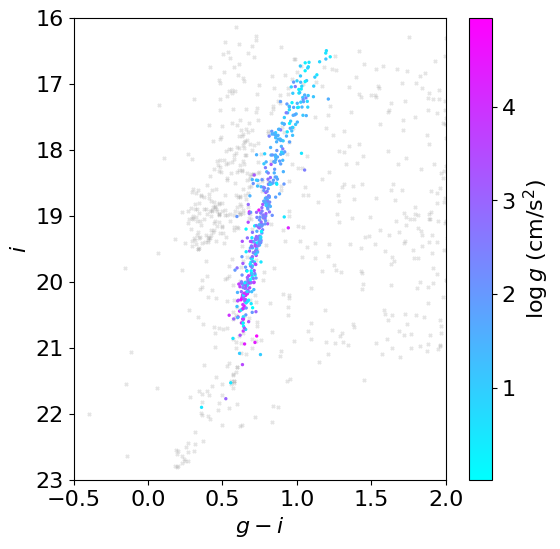

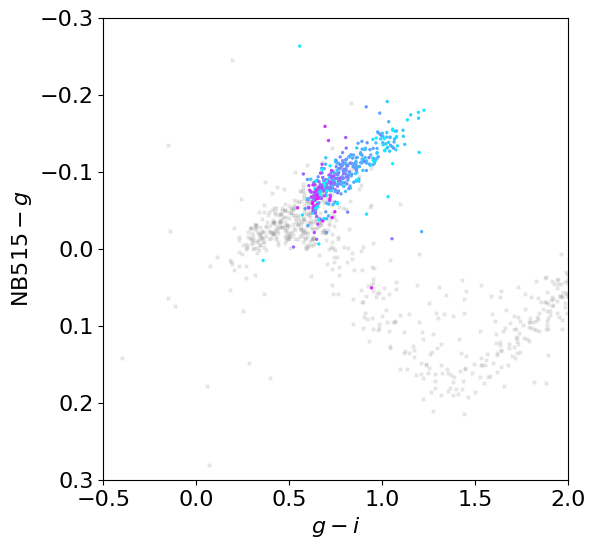

In [106]:
plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[nonmems], i[nonmems], s=5, alpha=0.2, marker='x', color='gray')
plt.scatter((g-i)[mems], i[mems], c=cat.loc[mems,'stage_2_logg'], s=2, alpha=1.0, cmap='cool')
plt.colorbar(label=r'$\log g$ (cm/s$^2$)')
plt.xlim(-0.5, 2.0)
plt.ylim(23, 16)
plt.xlabel(r'$g - i$')
plt.ylabel(r'$i$')
plt.show()

plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[nonmems], (n-g)[nonmems], s=5, alpha=0.2, marker='x', color='gray')
plt.scatter((g-i)[mems], (n-g)[mems], c=cat.loc[mems,'stage_2_logg'], s=2, alpha=1.0, cmap='cool')
plt.xlim(-0.5, 2.0)
plt.ylim(0.3, -0.3)
plt.xlabel(r'$g - i$')
plt.ylabel(r'${\rm NB515} - g$')
plt.show()

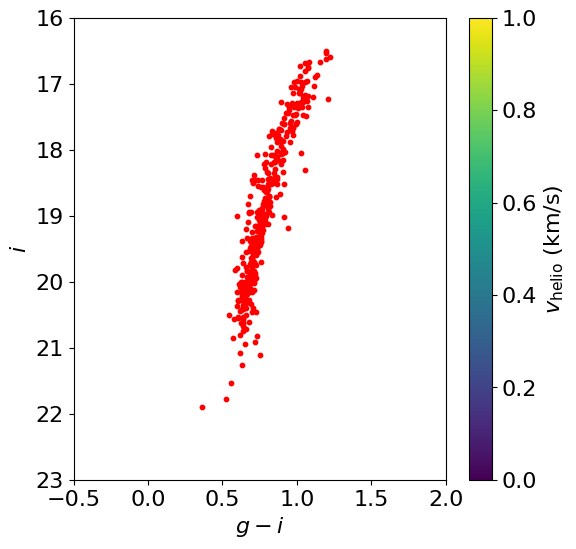

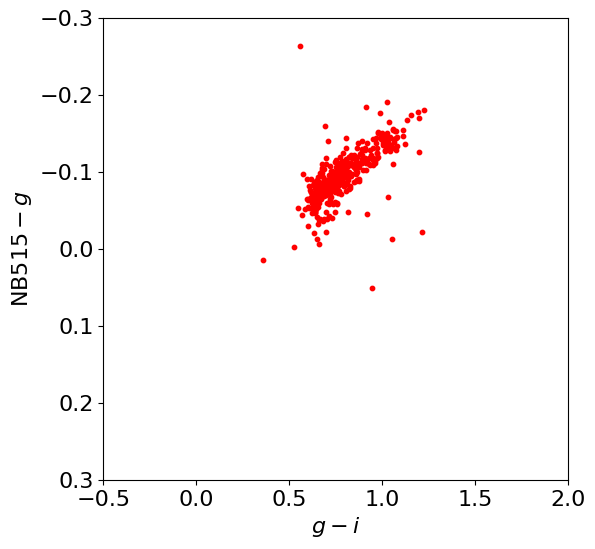

In [107]:
plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[mask], i[mask], c=cat.loc[mask,'stage_1_redshift'], s=2, alpha=1.0, cmap='cool')
plt.scatter((g-i)[mems], i[mems], color='red', s=10, alpha=1.0)
plt.colorbar(label=r'$v_{\rm helio}$ (km/s)')
plt.xlim(-0.5, 2.0)
plt.ylim(23, 16)
plt.xlabel(r'$g - i$')
plt.ylabel(r'$i$')

plt.figure(figsize=(6, 6)) 
plt.scatter((g-i)[mask], (n-g)[mask], c=cat.loc[mask,'stage_1_redshift'], s=2, alpha=1.0, cmap='cool')
plt.scatter((g-i)[mems], (n-g)[mems], color='red', s=10, alpha=1.0)
plt.xlim(-0.5, 2.0)
plt.ylim(0.3, -0.3)
plt.xlabel(r'$g - i$')
plt.ylabel(r'${\rm NB515} - g$')
plt.show()

In [108]:
mems = (cat['stage_1_redshift'] > vlow) & (cat['stage_1_redshift'] < vhigh) & (cat['stage_2_logg'] < 4.99) & (cat['priority'] <= 2) & ~pd.isna(cat['priority'])
nonmems = ~mems
mems = mask & mems
nonmems = mask & nonmems

/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/2489709313.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks_hms)
/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/2489709313.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ticks_dms)


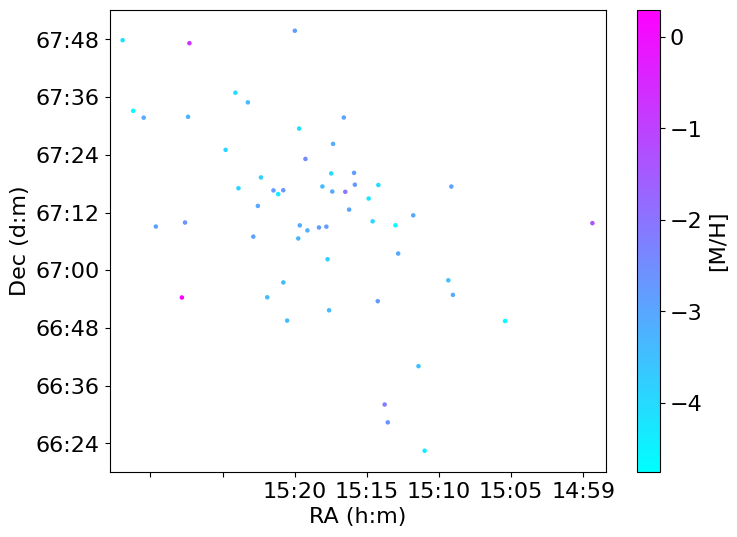

In [109]:
plt.figure(figsize=(8, 6))
dec0 = np.deg2rad(np.mean(cat['Dec']))
plt.scatter(cat.loc[nonmems,'RA']*np.cos(dec0), cat.loc[nonmems,'Dec'], s=5, alpha=0.2, marker='x', color='gray')
plt.scatter(cat.loc[mems,'RA']*np.cos(dec0), cat.loc[mems,'Dec'], s=5, alpha=1.0, c=cat.loc[mems,'stage_2_zscale'], cmap='cool')
plt.colorbar(label=r'[M/H]')
plt.xlabel('RA (h:m)')
plt.ylabel('Dec (d:m)')
plt.gca().invert_xaxis()
ax = plt.gca()
xticks = ax.get_xticks() / np.cos(dec0)
yticks = ax.get_yticks()
ticks_hms = Angle(xticks, unit=u.deg).to_string(unit=u.hour, sep=':', precision=0, decimal=False, alwayssign=False, fields=2)
ticks_dms = Angle(yticks, unit=u.deg).to_string(unit=u.deg, sep=':', precision=0, decimal=False, alwayssign=False, fields=2)
ax.set_xticklabels(ticks_hms)
ax.set_yticklabels(ticks_dms)
plt.axis('equal')
plt.show()

Text(0, 0.5, '[$\\alpha$/M]')

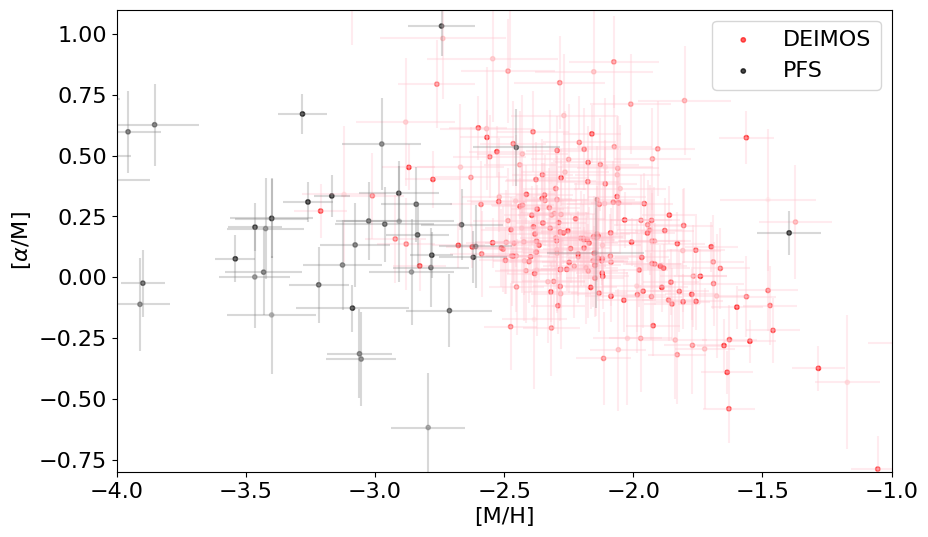

In [110]:
deimos = Table.read('umi_moogify_member.fits.gz', format='fits')
#deimos = deimos.to_pandas()
deimos = deimos[(deimos['FEHERR'] < 0.3) & (deimos['ALPHAFEERR'] < 0.3) & (deimos['FEH'] > -4.0) & (deimos['FEH'] < 0.0) & (deimos['ALPHAFE'] > -0.8) & (deimos['ALPHAFE'] < 1.2)]
alpha_deimos = np.array((0.3 - deimos['ALPHAFEERR']) / 0.3)

mask = mems & (cat['stage_2_zscale_err'] < 0.3) & (cat['stage_2_alpha_err'] < 0.3) & (cat['priority'] <= 2) & (cat['stage_2_alpha'] < 1.19) & (cat['stage_2_alpha'] > -0.79)
alpha = np.array((0.3 - cat.loc[mask, 'stage_2_alpha_err']) / 0.3)

plt.figure(figsize=(10, 6))
plt.errorbar(deimos['FEH'], deimos['ALPHAFE'], xerr=deimos['FEHERR'], yerr=deimos['ALPHAFEERR'], fmt='.', markersize=0.1, alpha=0.3, color='pink')
plt.scatter(deimos['FEH'], deimos['ALPHAFE'], s=10, c='red', alpha=alpha_deimos, label='DEIMOS')
plt.errorbar(cat.loc[mask, 'stage_2_zscale'], cat.loc[mask,'stage_2_alpha'], xerr=cat.loc[mask,'stage_2_zscale_err'], yerr=cat.loc[mask,'stage_2_alpha_err'], fmt='.', markersize=0.1, alpha=0.3, color='gray')
plt.scatter(cat.loc[mask, 'stage_2_zscale'], cat.loc[mask,'stage_2_alpha'], s=10, c='black', alpha=alpha, label='PFS')
plt.legend()
#plt.colorbar(label=r'$\log g$')
plt.xlim(-4, -1)
plt.ylim(-0.8, 1.1)
plt.xlabel(r'[M/H]')
plt.ylabel(r'[$\alpha$/M]')

/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/3427438980.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks_hms)
/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/3427438980.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ticks_dms)


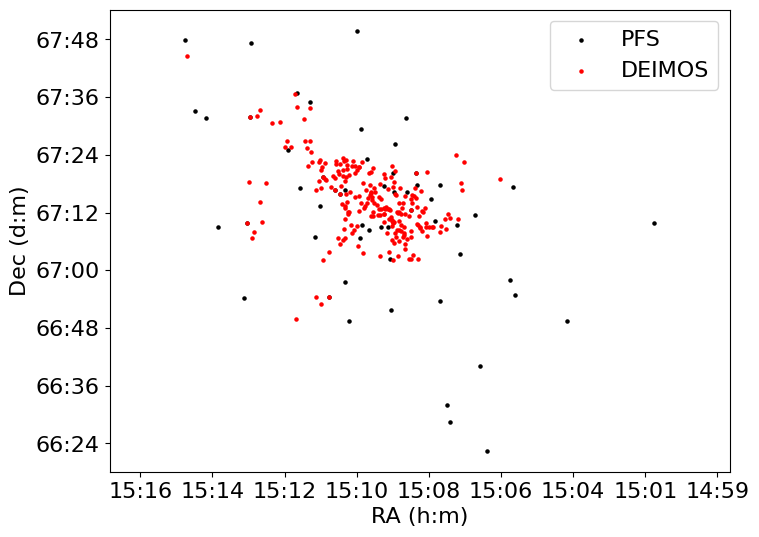

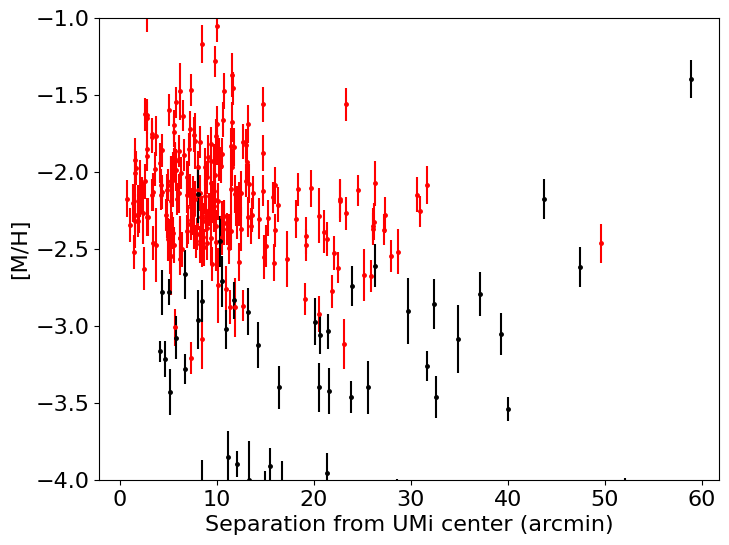

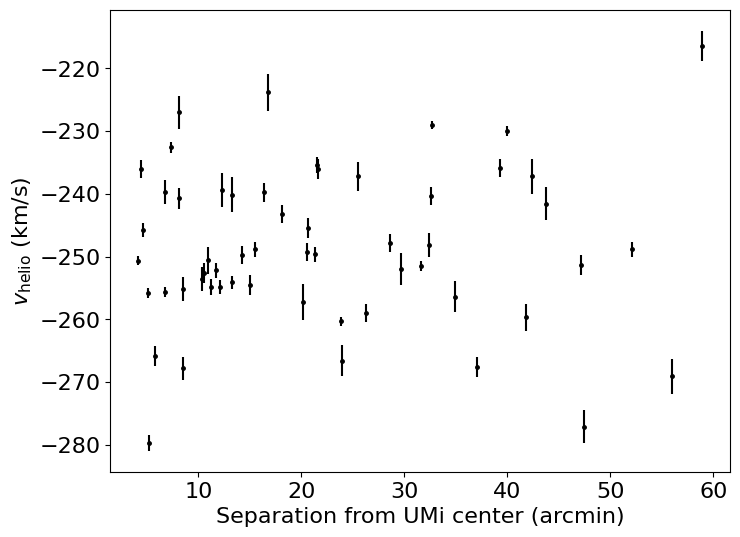

In [111]:
plt.figure(figsize=(8, 6))
dec0 = np.deg2rad(np.mean(cat['Dec']))
plt.scatter(cat.loc[mems,'RA']*np.cos(dec0), cat.loc[mems,'Dec'], s=5, alpha=1.0, c='black', label='PFS')
plt.scatter(deimos['RA']*np.cos(dec0), deimos['DEC'], s=5, alpha=1.0, c='red', label='DEIMOS')
plt.xlabel('RA (h:m)')
plt.ylabel('Dec (d:m)')
plt.gca().invert_xaxis()
plt.legend()
ax = plt.gca()
xticks = ax.get_xticks() / np.cos(dec0)
yticks = ax.get_yticks()
ticks_hms = Angle(xticks, unit=u.deg).to_string(unit=u.hour, sep=':', precision=0, decimal=False, alwayssign=False, fields=2)
ticks_dms = Angle(yticks, unit=u.deg).to_string(unit=u.deg, sep=':', precision=0, decimal=False, alwayssign=False, fields=2)
ax.set_xticklabels(ticks_hms)
ax.set_yticklabels(ticks_dms)
plt.axis('equal')
plt.show()

bins = np.linspace(0, 60, 10)
mask_deimos = (deimos['FEH'] > -4.0) & (deimos['FEH'] < 0.0) & (deimos['FEHERR'] < 0.3)
skycoord0 = SkyCoord('15 09 11  +67 12 52', unit=(u.hour, u.deg))
skycoord_deimos = SkyCoord(ra=deimos['RA']*u.deg, dec=deimos['DEC']*u.deg, unit=u.deg)
skycoord_cat = SkyCoord(ra=cat['RA']*u.deg, dec=cat['Dec']*u.deg, unit=u.deg)
plt.figure(figsize=(8, 6))
plt.errorbar(skycoord_deimos[mask_deimos].separation(skycoord0).arcmin, deimos['FEH'][mask_deimos], deimos['FEHERR'][mask_deimos], markersize=5, fmt='.', alpha=1.0, c='red', label='DEIMOS')
plt.errorbar(skycoord_cat[mems].separation(skycoord0).arcmin, cat.loc[mems,'stage_2_zscale'], cat.loc[mems,'stage_2_zscale_err'], markersize=5, fmt='.', alpha=1.0, c='black', label='PFS')
for j in range(len(bins)-1):
    mask_deimos_bin = (skycoord_deimos[mask_deimos].separation(skycoord0).arcmin >= bins[j]) & (skycoord_deimos[mask_deimos].separation(skycoord0).arcmin < bins[j+1])
    mask_cat_bin = (skycoord_cat[mems].separation(skycoord0).arcmin >= bins[j]) & (skycoord_cat[mems].separation(skycoord0).arcmin < bins[j+1])
    #if np.sum(mask_deimos_bin) > 0:
    #    plt.errorbar(np.mean(skycoord_deimos[mask_deimos][mask_deimos_bin].separation(skycoord0).arcmin), np.mean(deimos['FEH'][mask_deimos][mask_deimos_bin]), yerr=np.std(deimos['FEH'][mask_deimos][mask_deimos_bin]), fmt='o', color='red', markersize=5, alpha=0.5)
    #if np.sum(mask_cat_bin) > 0:
    #    plt.errorbar(np.mean(skycoord_cat[mems][mask_cat_bin].separation(skycoord0).arcmin), np.mean(cat.loc[mems,'stage_2_zscale'][mask_cat_bin]), yerr=np.std(cat.loc[mems,'stage_2_zscale'][mask_cat_bin])/np.sqrt(len(mask_cat_bin)), fmt='o', color='magenta', markersize=5, alpha=1.0)
plt.xlabel('Separation from UMi center (arcmin)')
plt.ylabel(r'[M/H]')
plt.ylim(-4.0, -1.0)
plt.show()

plt.figure(figsize=(8, 6))
plt.errorbar(skycoord_cat[mems].separation(skycoord0).arcmin, cat.loc[mems,'stage_1_redshift'], cat.loc[mems,'stage_1_redshift_err'], markersize=5, fmt='.', alpha=1.0, c='black')
plt.errorbar(skycoord_cat[nonmems].separation(skycoord0).arcmin, cat.loc[nonmems,'stage_1_redshift'], cat.loc[nonmems,'stage_1_redshift_err'], markersize=5, fmt='x', alpha=0.5, c='black')
plt.xlabel('Separation from UMi center (arcmin)')
plt.ylabel(r'$v_{\rm helio}$ (km/s)')
plt.show()

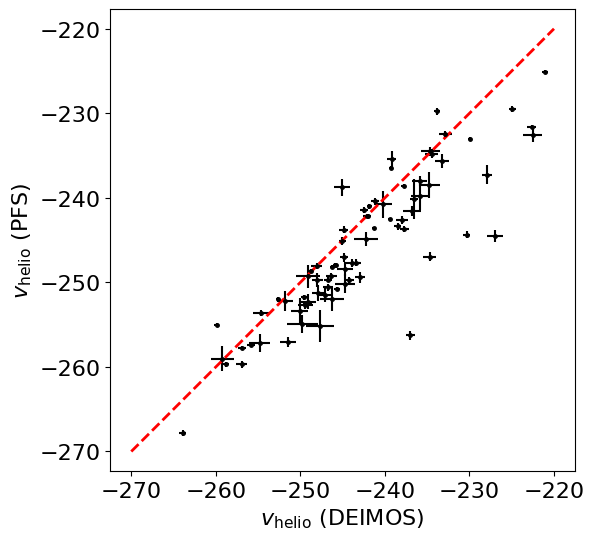

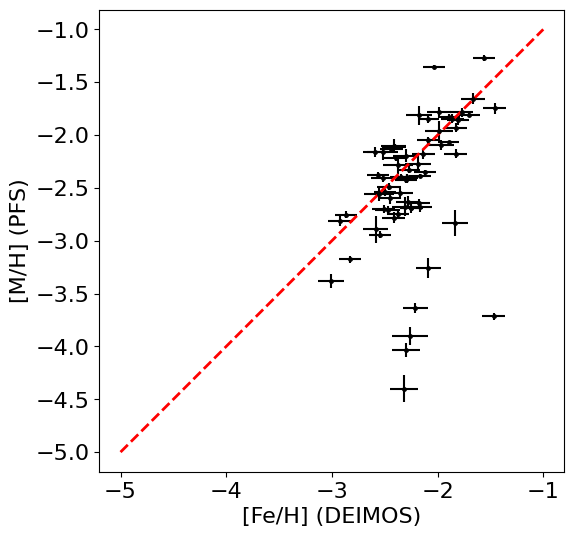

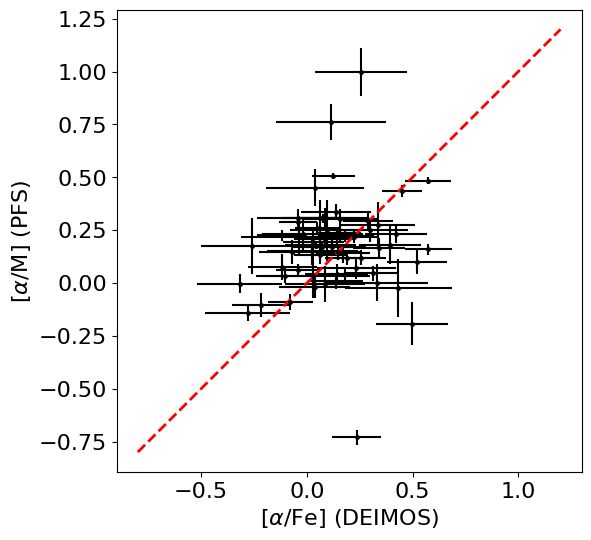

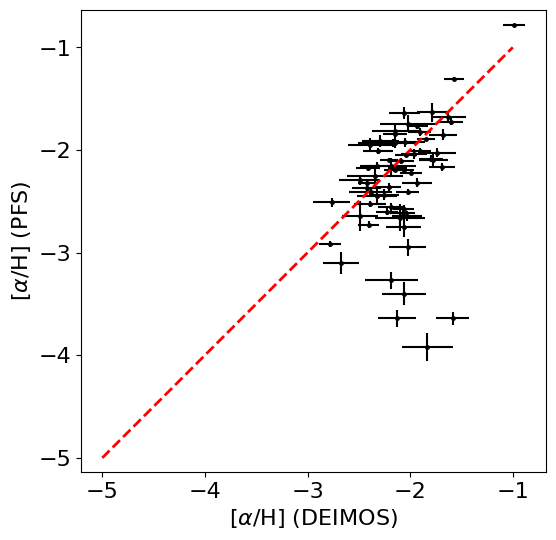

In [112]:
idx_deimos, d2d_deimos, _ = skycoord_cat.match_to_catalog_sky(skycoord_deimos)
max_sep = 0.5 * u.arcsec

# Only keep matches within max_sep
mask = (d2d_deimos < max_sep)

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['VHELIO'][idx_deimos[mask]], cat.loc[mask, 'stage_1_redshift'], xerr=deimos['VRERR'][idx_deimos[mask]], yerr=cat.loc[mask, 'stage_1_redshift_err'], fmt='.', markersize=5, alpha=1.0, c='black')
plt.plot([-270, -220], [-270, -220], color='red', linestyle='--', linewidth=2)
plt.xlabel(r'$v_{\rm helio}$ (DEIMOS)')
plt.ylabel(r'$v_{\rm helio}$ (PFS)')
plt.xlim(-270, -220)
plt.ylim(-270, -220)
plt.axis('equal')
plt.show()

mask = (d2d_deimos < max_sep) & (cat['stage_2_zscale_err'] < 0.15) & (cat['stage_2_alpha_err'] < 0.15) & (cat['stage_2_alpha'] < 1.19) & (cat['stage_2_alpha'] > -0.79)

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['FEH'][idx_deimos[mask]], cat.loc[mask, 'stage_2_zscale'], xerr=deimos['FEHERR'][idx_deimos[mask]], yerr=cat.loc[mask, 'stage_2_zscale_err'], fmt='.', markersize=5, alpha=1.0, c='black')
plt.plot([-5, -1], [-5, -1], color='red', linestyle='--', linewidth=2)
plt.xlabel(r'[Fe/H] (DEIMOS)')
plt.ylabel(r'[M/H] (PFS)')
plt.xlim(-5, -1)
plt.ylim(-5, -1)
plt.axis('equal')
plt.show()

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['ALPHAFE'][idx_deimos[mask]], cat.loc[mask, 'stage_2_alpha'], xerr=deimos['ALPHAFEERR'][idx_deimos[mask]], yerr=cat.loc[mask, 'stage_2_alpha_err'], fmt='.', markersize=5, alpha=1.0, c='black')
plt.plot([-0.8, 1.2], [-0.8, 1.2], color='red', linestyle='--', linewidth=2)
plt.xlabel(r'[$\alpha$/Fe] (DEIMOS)')
plt.ylabel(r'[$\alpha$/M] (PFS)')
plt.xlim(-0.8, 1.2)
plt.ylim(-0.8, 1.2)
plt.axis('equal')
plt.show()

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['ALPHAFE'][idx_deimos[mask]]+deimos['FEH'][idx_deimos[mask]], cat.loc[mask, 'stage_2_alpha']+cat.loc[mask, 'stage_2_zscale'], xerr=deimos['ALPHAFEERR'][idx_deimos[mask]], yerr=cat.loc[mask, 'stage_2_alpha_err'], fmt='.', markersize=5, alpha=1.0, c='black')
plt.plot([-5, -1], [-5, -1], color='red', linestyle='--', linewidth=2)
plt.xlabel(r'[$\alpha$/H] (DEIMOS)')
plt.ylabel(r'[$\alpha$/H] (PFS)')
plt.xlim(-5, -1)
plt.ylim(-5, -1)
plt.axis('equal')
plt.show()

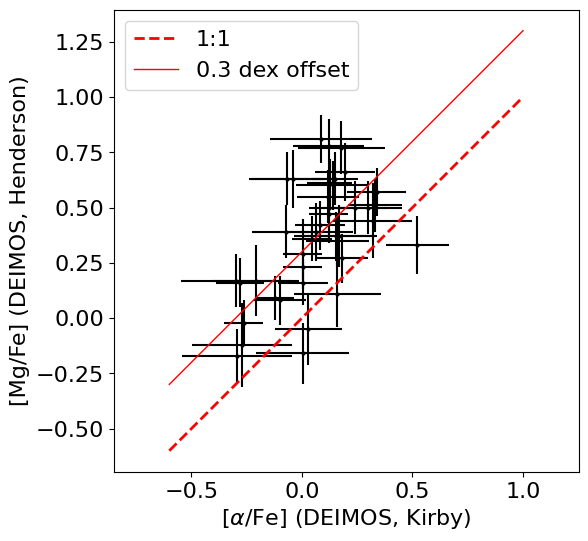

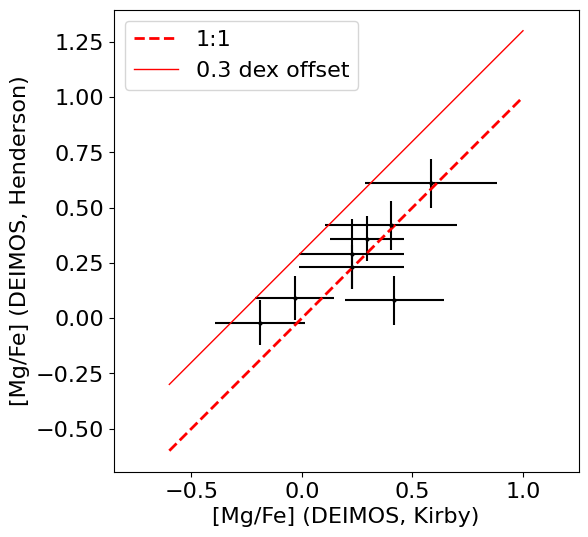

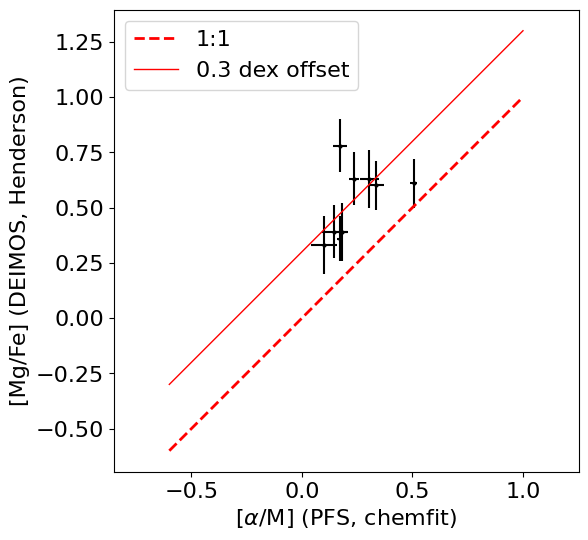

In [113]:
smaug = pd.read_csv('fulldataUMi_NMOL17.csv')  # results of smaug
skycoord_smaug = SkyCoord(ra=smaug['RA']*u.deg, dec=smaug['Dec']*u.deg, unit=u.deg)
idx_smaug_deimos, d2d_smaug_deimos, _ = skycoord_smaug.match_to_catalog_sky(skycoord_deimos)
idx_smaug_cat, d2d_smaug_cat, _ = skycoord_smaug.match_to_catalog_sky(skycoord_cat)
maskd = (d2d_smaug_deimos < max_sep) & np.isfinite(smaug['[Mg/Fe]']) & (smaug['errup([Mg/Fe])'] < 0.3) & (smaug['errdown([Mg/Fe])'] < 0.3)
maskc = (d2d_smaug_cat < max_sep) & np.isfinite(smaug['[Mg/Fe]']) & (smaug['errup([Mg/Fe])'] < 0.3) & (smaug['errdown([Mg/Fe])'] < 0.3)

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['ALPHAFE'][idx_smaug_deimos[maskd]], smaug['[Mg/Fe]'][maskd], 
             xerr=deimos['ALPHAFEERR'][idx_smaug_deimos[maskd]], yerr=smaug['errup([Mg/Fe])'][maskd], fmt='.', markersize=4, color='black')
plt.plot([-0.6, 1.0], [-0.6, 1.0], color='red', linestyle='--', linewidth=2, label='1:1')
plt.plot([-0.6, 1.0], 0.3+np.array([-0.6, 1.0]), color='red', linestyle='-', linewidth=1, label='0.3 dex offset')
plt.legend()
plt.xlabel(r'[$\alpha$/Fe] (DEIMOS, Kirby)')
plt.ylabel(r'[Mg/Fe] (DEIMOS, Henderson)')
plt.xlim(-0.6, 1.0)
plt.ylim(-0.6, 1.0)
plt.axis('equal')
plt.show()

maskd = (d2d_smaug_deimos < max_sep) & np.isfinite(smaug['[Mg/Fe]']) & (smaug['errup([Mg/Fe])'] < 0.3) & (smaug['errdown([Mg/Fe])'] < 0.3) & (deimos['MGFEERR'][idx_smaug_deimos] < 0.3) & (deimos['MGFE'][idx_smaug_deimos] > -0.8) & (deimos['MGFE'][idx_smaug_deimos] < 1.2)

plt.figure(figsize=(6, 6))
plt.errorbar(deimos['MGFE'][idx_smaug_deimos[maskd]], smaug['[Mg/Fe]'][maskd], 
             xerr=deimos['MGFEERR'][idx_smaug_deimos[maskd]], yerr=smaug['errup([Mg/Fe])'][maskd], fmt='.', markersize=4, color='black')
plt.plot([-0.6, 1.0], [-0.6, 1.0], color='red', linestyle='--', linewidth=2, label='1:1')
plt.plot([-0.6, 1.0], 0.3+np.array([-0.6, 1.0]), color='red', linestyle='-', linewidth=1, label='0.3 dex offset')
plt.legend()
plt.xlabel(r'[Mg/Fe] (DEIMOS, Kirby)')
plt.ylabel(r'[Mg/Fe] (DEIMOS, Henderson)')
plt.xlim(-0.6, 1.0)
plt.ylim(-0.6, 1.0)
plt.axis('equal')
plt.show()

plt.figure(figsize=(6, 6))
plt.errorbar(cat.loc[idx_smaug_cat[maskc],'stage_2_alpha'], smaug['[Mg/Fe]'][maskc], 
             xerr=cat.loc[idx_smaug_cat[maskc],'stage_2_alpha_err'], yerr=smaug['errup([Mg/Fe])'][maskc], fmt='.', markersize=4, color='black')
plt.plot([-0.6, 1.0], [-0.6, 1.0], color='red', linestyle='--', linewidth=2, label='1:1')
plt.plot([-0.6, 1.0], 0.3+np.array([-0.6, 1.0]), color='red', linestyle='-', linewidth=1, label='0.3 dex offset')
plt.legend()
plt.xlabel(r'[$\alpha$/M] (PFS, chemfit)')
plt.ylabel(r'[Mg/Fe] (DEIMOS, Henderson)')
plt.xlim(-0.6, 1.0)
plt.ylim(-0.6, 1.0)
plt.axis('equal')
plt.show()

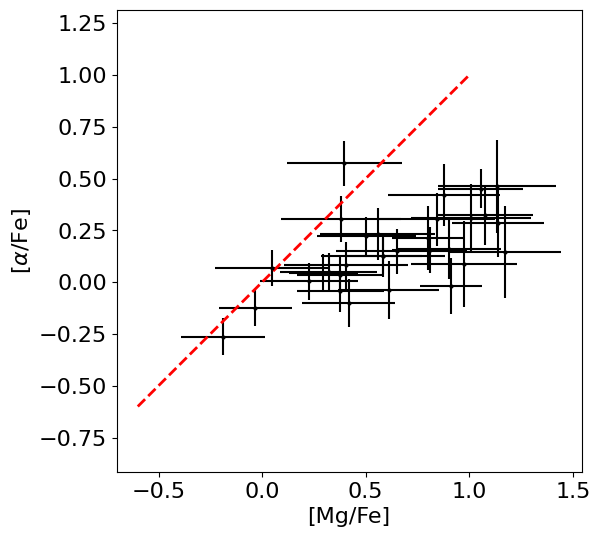

In [114]:
maskd = (deimos['MGFE'] > -0.8) & (deimos['MGFE'] < 1.2) & (deimos['MGFEERR'] < 0.3) & (deimos['ALPHAFE'] > -0.8) & (deimos['ALPHAFE'] < 1.2) & (deimos['ALPHAFEERR'] < 0.3)
plt.figure(figsize=(6, 6))
plt.errorbar(deimos['MGFE'][maskd], deimos['ALPHAFE'][maskd], xerr=deimos['MGFEERR'][maskd], yerr=deimos['ALPHAFEERR'][maskd], fmt='.', markersize=4, color='black')
plt.plot([-0.6, 1.0], [-0.6, 1.0], color='red', linestyle='--', linewidth=2, label='1:1')
plt.xlabel(r'[Mg/Fe]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlim(-0.6, 1.0)
plt.ylim(-0.6, 1.0)
plt.axis('equal')
plt.show()

In [115]:
#m = (np.abs(deimos['FEH'][idx_deimos[mask]] - cat.loc[mask, 'stage_2_zscale']) < 0.1)
#m = np.round(cat.loc[mask, 'stage_2_teff']) == 5042
#m = (g[mask] < 18.5) & (cat.loc[mask, 'stage_2_zscale'] > -2.0)

# Choose which magnitude range you want to see.  Only look at stars with zscale within 0.1 dex of the deimos FEH.

m = (np.abs(deimos['FEH'][idx_deimos[mask]] - cat.loc[mask, 'stage_2_zscale']) < 0.1) \
            & (g[mask] < 18.5)
#m = (np.abs(deimos['FEH'][idx_deimos[mask]] - cat.loc[mask, 'stage_2_zscale']) < 0.1) \
#            & (g[mask] < 20.0) & (g[mask] > 19.7)
#m = (np.abs(deimos['FEH'][idx_deimos[mask]] - cat.loc[mask, 'stage_2_zscale']) < 0.1) \
#            & (g[mask] < 21.0) & (g[mask] > 20.7)


id = 0

maskd = idx_deimos[mask][m][id]
#print(deimos['FEH'][maskd])
print(cat.loc[mask, 'stage_2_teff'][m].values[id])
print(cat.loc[mask, 'stage_2_logg'][m].values[id])
print(cat.loc[mask, 'stage_2_zscale'][m].values[id])
print(g[mask][m][id])
print(i[mask][m][id])

#catId = cat.loc[mask, 'catId'][m].values[id]
#objId = cat.loc[mask, 'objId'][m].values[id]


4653.806138513888
0.9049964529929609
-2.3975836962266937
18.011150609500003
17.0486562316


In [116]:

import pickle
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler
from astropy.nddata import StdDevUncertainty
import copy, time


objId = 25769809641
catId = 10092


# Susie's job for July 4:
# Finish the following function.  It should make a plot of the spectrum of the star with objId.
# To finish the function, Susie will need to copy some of the code below and paste it to the end of this cell.
# Be careful to indent the code correctly so that it is part of the function.
# bonus: Add a "wavelength_range" keyword so that you can specify the start and end of the wavelength range to plot.
# To save: CMD+S

def plot_spectrum(objId, wl_range=[4500, 5500]):
    fname = str(catId)+'x'+str(objId)+'.pkl'
    print(fname)

    f = open(fname, 'rb')
    fit = pickle.load(f)
    f.close()
    def coadd_spectrum(fit):

        #resampler = FluxConservingResampler()
        resampler = LinearInterpolatedResampler()
        wl_all = None

        for arm in np.unique(fit['stage_2']['extra']['arm_index']):
            #uncomment this to see the red channel
            #if arm < 2:
            #    continue
            maskf = fit['stage_2']['extra']['arm_index'] == arm
            wl = fit['stage_2']['extra']['observed']['wl'][maskf]
            
            flux = fit['stage_2']['extra']['observed']['flux'][maskf]
            error = fit['stage_2']['extra']['observed']['ivar'][maskf] ** (-0.5)
            
            wl_model = fit['stage_2']['extra']['model']['wl'][maskf]
            flux_model = fit['stage_2']['extra']['model']['cont'][maskf] * fit['stage_2']['extra']['model']['flux'][maskf]

            spec = Spectrum1D(spectral_axis=wl*u.AA, flux=flux*u.Unit("erg cm-2 s-1 AA-1"), uncertainty=StdDevUncertainty(error, unit=u.Unit("erg cm-2 s-1 AA-1")))
            spec_model = Spectrum1D(spectral_axis=wl_model*u.AA, flux=flux_model*u.Unit("erg cm-2 s-1 AA-1"))
            
            if wl_all is None:
                spec_all = copy.deepcopy(spec)
                wl_all = spec.spectral_axis
                
                spec_model_all = resampler(spec_model, wl_all)
            else:
                rebinned_spec = resampler(spec, wl_all)
                rebinned_spec_model = resampler(spec_model, wl_all)
                
                weight1 = spec_all.uncertainty.array**-2
                weight2 = rebinned_spec.uncertainty.array**-2
                
                nanmask = np.isnan(rebinned_spec.flux.value) | np.isnan(weight2)
                weight2[nanmask] = 0
                rebinned_spec.flux.value[nanmask] = 0
                
                # Coadd the observations weighted by ivar.
                newflux = (spec_all.flux.value*weight1 + rebinned_spec.flux.value*weight2) / (weight1 + weight2)
                weight = (weight1 + weight2)
                
                nanmask = np.isnan(rebinned_spec_model.flux.value)
                weight2[nanmask] = 0
                
                # Coadd the model spectra with the same weights as the observed spectra.
                rebinned_spec_model.flux.value[nanmask] = 0
                newflux_model = (spec_model_all.flux.value*weight1 + rebinned_spec_model.flux.value*weight2) / (weight1 + weight2)
                
                #newflux = (spec_all.flux.value + rebinned_spec.flux.value)
                spec_all = Spectrum1D(spectral_axis=spec_all.spectral_axis, flux=newflux*u.Unit("erg cm-2 s-1 AA-1"), uncertainty=StdDevUncertainty(1/np.sqrt(weight), unit=u.Unit("erg cm-2 s-1 AA-1")))
                spec_model_all = Spectrum1D(spectral_axis=spec_model_all.spectral_axis, flux=newflux_model*u.Unit("erg cm-2 s-1 AA-1"))
                
                '''
                wl_coadd = spec_all.spectral_axis.value
                flux_coadd = spec_all.flux.value
                error_coadd = spec_all.uncertainty.array

                plt.errorbar(wl_coadd, flux_coadd, yerr = error_coadd, fmt = 'c.')
                plt.xlim(np.array([-10, 10])+wl0)
                plt.ylim(np.min(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]) / 1.1, 1.1 * np.max(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]))
                plt.fill_between(np.array([-1.5, 1.5])+wl0, 0, 1.2 * np.max(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]), color='gray', alpha=0.3)

                plt.xlabel(r'rest air wavelength [${\rm \AA}$]')
                plt.ylabel('flux [pfsCalibrated units]')
                plt.show()
                #input('Press Enter to continue...')
                '''
        return spec_all, spec_model_all
        
    spec_all, spec_model_all = coadd_spectrum(fit)
    wl = spec_all.spectral_axis.value
    flux = spec_all.flux.value
    error = spec_all.uncertainty.array
    wl_model = spec_model_all.spectral_axis.value
    flux_model = spec_model_all.flux.value

    if wl_range:
        wave_start, wave_end = wl_range
        mask = (wl >= wave_start) & (wl <= wave_end)
        wl = wl[mask]
        flux = flux[mask]
        error = error[mask]
        
        mask_model = (wl_model >= wave_start) & (wl_model <= wave_end)
        wl_model = wl_model[mask_model]
        flux_model = flux_model[mask_model]

    plt.figure(figsize=(10, 6))
    plt.errorbar(wl, flux, yerr=error, fmt='.', markersize=2, color='blue', label='Observed Spectrum')
    plt.plot(wl_model, flux_model, 'k-', color='red', label='Model Spectrum')
    plt.xlabel(r'rest air wavelength [$\AA$]')
    plt.ylabel('flux [pfsCalibrated units]')
    if wl_range:
        plt.xlim(wl_range)
    else:
        plt.xlim(np.min(wl), np.max(wl))
    fluxmask = (np.isfinite(flux))
    plt.ylim(0, 1.2 * np.max(flux[fluxmask]))
    
    plt.legend()
    plt.title(f'Spectrum of Object {objId}')
    plt.show()


10092x25769809641.pkl


/var/folders/fj/9rbrpnsd2rng01jy11xrbcq80000gn/T/ipykernel_8410/3146290605.py:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(wl_model, flux_model, 'k-', color='red', label='Model Spectrum')


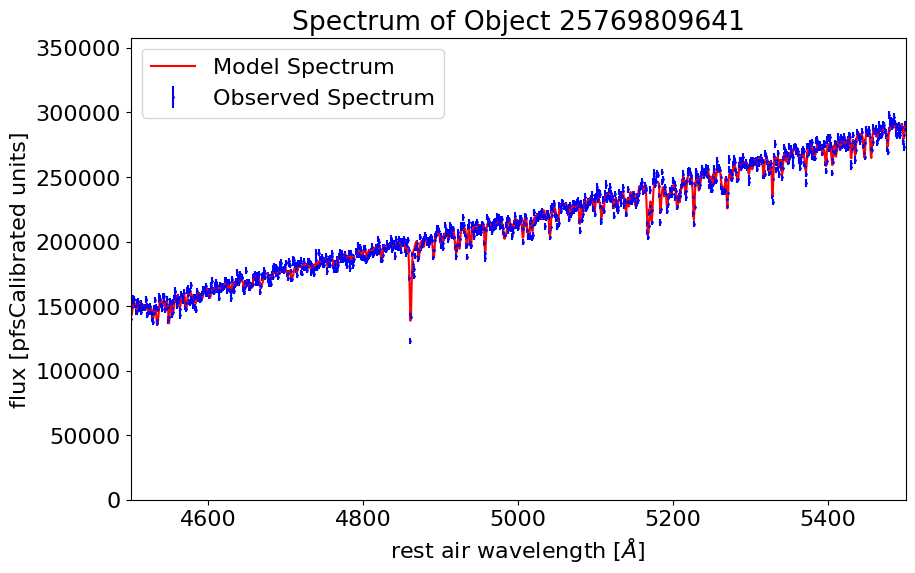

In [117]:
plot_spectrum(objId)

In [118]:
# Coadd the spectra.

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler
from astropy.nddata import StdDevUncertainty
import copy, time


def coadd_spectrum(fit):

    #resampler = FluxConservingResampler()
    resampler = LinearInterpolatedResampler()
    wl_all = None

    for arm in np.unique(fit['stage_2']['extra']['arm_index']):
        #uncomment this to see the red channel
        #if arm < 2:
        #    continue
        maskf = fit['stage_2']['extra']['arm_index'] == arm
        wl = fit['stage_2']['extra']['observed']['wl'][maskf]
        
        flux = fit['stage_2']['extra']['observed']['flux'][maskf]
        error = fit['stage_2']['extra']['observed']['ivar'][maskf] ** (-0.5)
        
        wl_model = fit['stage_2']['extra']['model']['wl'][maskf]
        flux_model = fit['stage_2']['extra']['model']['cont'][maskf] * fit['stage_2']['extra']['model']['flux'][maskf]

        spec = Spectrum1D(spectral_axis=wl*u.AA, flux=flux*u.Unit("erg cm-2 s-1 AA-1"), uncertainty=StdDevUncertainty(error, unit=u.Unit("erg cm-2 s-1 AA-1")))
        spec_model = Spectrum1D(spectral_axis=wl_model*u.AA, flux=flux_model*u.Unit("erg cm-2 s-1 AA-1"))
        
        if wl_all is None:
            spec_all = copy.deepcopy(spec)
            wl_all = spec.spectral_axis
            
            spec_model_all = resampler(spec_model, wl_all)
        else:
            rebinned_spec = resampler(spec, wl_all)
            rebinned_spec_model = resampler(spec_model, wl_all)
            
            weight1 = spec_all.uncertainty.array**-2
            weight2 = rebinned_spec.uncertainty.array**-2
            
            nanmask = np.isnan(rebinned_spec.flux.value) | np.isnan(weight2)
            weight2[nanmask] = 0
            rebinned_spec.flux.value[nanmask] = 0
            
            # Coadd the observations weighted by ivar.
            newflux = (spec_all.flux.value*weight1 + rebinned_spec.flux.value*weight2) / (weight1 + weight2)
            weight = (weight1 + weight2)
            
            nanmask = np.isnan(rebinned_spec_model.flux.value)
            weight2[nanmask] = 0
            
            # Coadd the model spectra with the same weights as the observed spectra.
            rebinned_spec_model.flux.value[nanmask] = 0
            newflux_model = (spec_model_all.flux.value*weight1 + rebinned_spec_model.flux.value*weight2) / (weight1 + weight2)
            
            #newflux = (spec_all.flux.value + rebinned_spec.flux.value)
            spec_all = Spectrum1D(spectral_axis=spec_all.spectral_axis, flux=newflux*u.Unit("erg cm-2 s-1 AA-1"), uncertainty=StdDevUncertainty(1/np.sqrt(weight), unit=u.Unit("erg cm-2 s-1 AA-1")))
            spec_model_all = Spectrum1D(spectral_axis=spec_model_all.spectral_axis, flux=newflux_model*u.Unit("erg cm-2 s-1 AA-1"))
            
            '''
            wl_coadd = spec_all.spectral_axis.value
            flux_coadd = spec_all.flux.value
            error_coadd = spec_all.uncertainty.array

            plt.errorbar(wl_coadd, flux_coadd, yerr = error_coadd, fmt = 'c.')
            plt.xlim(np.array([-10, 10])+wl0)
            plt.ylim(np.min(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]) / 1.1, 1.1 * np.max(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]))
            plt.fill_between(np.array([-1.5, 1.5])+wl0, 0, 1.2 * np.max(flux_coadd[(wl_coadd > wl0-10) & (wl_coadd < wl0+10)]), color='gray', alpha=0.3)

            plt.xlabel(r'rest air wavelength [${\rm \AA}$]')
            plt.ylabel('flux [pfsCalibrated units]')
            plt.show()
            #input('Press Enter to continue...')
            '''
    return spec_all, spec_model_all
        

Text(0, 0.5, 'flux [pfsCalibrated units]')

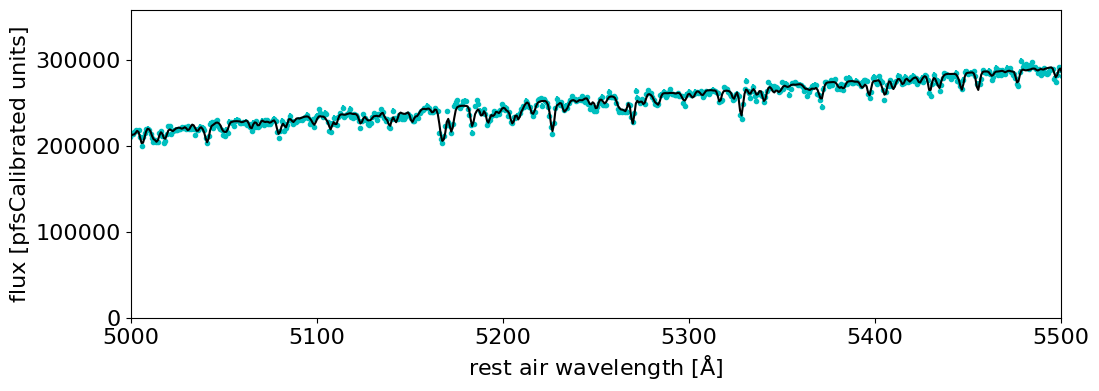

In [121]:
# Plot the coadded spectrum and the best-fit model.

# Make sure you have a fit object loaded, e.g.:
import pickle

# Replace with your actual file path
# Example: use a real file path, or use variables objId and catId if available
catId = 10092
objId = 25769809641
fname = f'{catId}x{objId}.pkl'
with open(fname, 'rb') as f:
	fit = pickle.load(f)

spec_all, spec_model_all = coadd_spectrum(fit)

plt.figure(figsize = [12, 4])

# Plot observed spectrum
wl = spec_all.spectral_axis.value
flux = spec_all.flux.value
error = spec_all.uncertainty.array
plt.errorbar(wl, flux, yerr = error, fmt = 'c.')    # plot the PFS observed spectrum in blue dots
# Another word for errorbar is "uncertainty."

# Plot best-fit model
wl_model = spec_model_all.spectral_axis.value
flux_model = spec_model_all.flux.value
plt.plot(wl_model, flux_model, 'k-', zorder = 20)   # plot the best-fit model spectrum as a black curve
mm = np.isfinite(flux)
plt.xlim(5000, 5500)
plt.ylim(0.0, 1.2 * np.max(flux[mm][(wl[mm] > 5000) & (wl[mm] < 5500)]))
#plt.xlim(8450, 8700)
#plt.ylim(0.0, 1.2 * np.max(flux[mm][(wl[mm] > 8450) & (wl[mm] < 8700)]))

plt.xlabel(r'rest air wavelength [${\rm \AA}$]')
plt.ylabel('flux [pfsCalibrated units]')

In [ ]:
plot_spectrum(objId)

In [ ]:
# Full example of a function.

def plot_height(height_in_cm, error, color='blue'):
    plt.errorbar([1], [height_in_cm], yerr=[error], fmt='o', color=color, label=f'Height: {height_in_cm} ± {error}')
    height_in_inches = height_in_cm / 2.54  # Convert cm to inches
    height_in_m = height_in_cm / 100.0  # Convert cm to meters
    return height_in_inches, height_in_m

In [ ]:
height_in_cm = 150
error = 20

print(plot_height(height_in_cm, error, color='green'))

In [ ]:
k= 8.6e-5
T= np.arange(0,10000)
delta_E= 10.2
ratio= np.exp(-delta_E/(k*T))
plt.plot(T,ratio)
plt.xlabel('Temperature (k)')
plt.ylabel('N2/N1')
plt.title('N2/N1 vs Temperature')
plt.grid(True)
plt.show()
